# **RECONHECIMENTO DE TEXTOS GERADOS POR INTELIGÊNCIA ARTIFICIAL: IMPLEMENTAÇÃO DAS PROPOSTAS APRESENTADAS**

---

SCC0633/SCC5908 - Processamento de Linguagem Natural - 2024

Professor: Thiago A.S Pardo.
Estagiário PAE: Germano A. Z. Jorge

## **Grupo: Generar**

* Jônatas Alves Lopes (11796552)
* Julio Cesar Galdino (15112607)
* Maria Victória Brandão Barros (12608692)
* Rebeca Vieira Carvalho (12543530)
* Thierry de Souza Araújo (12681094)

###Importando pacotes

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments, AdamW
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import torch
import pickle

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 17.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 17.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 23.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 19.8 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 

In [1]:
from datasets import Dataset

In [1]:
pip install -U accelerate==0.30.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.4/302.4 kB 5.2 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

In [2]:
import accelerate

### Observação inicial dos dados

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/BERT_data/AI_Human.csv')

In [ ]:
data

,text,generated
0,Cars. Cars have been around since they became ...,0.0
1,Transportation is a large necessity in most co...,0.0
2,"""America's love affair with it's vehicles seem...",0.0
3,How often do you ride in a car? Do you drive a...,0.0
4,Cars are a wonderful thing. They are perhaps o...,0.0
...,...,...
487230,Tie Face on Mars is really just a big misunder...,0.0
487231,The whole purpose of democracy is to create a ...,0.0
487232,I firmly believe that governments worldwide sh...,1.0
487233,I DFN't agree with this decision because a LFT...,0.0


O dataset é composto por duas colunas: a primeira indica o texto a ser analisado e a segunda indica o label daquele texto (1 indica que ele foi gerado por inteligência artificial e 0 indica que ele foi escrito por um humano). O dataset original contém um total de 487235 observações, mas optamos por utilizar apenas uma porção dos dados por questões de custo computacional.

In [ ]:
data['generated'].value_counts()

generated
0.0    305797
1.0    181438
Name: count, dtype: int64

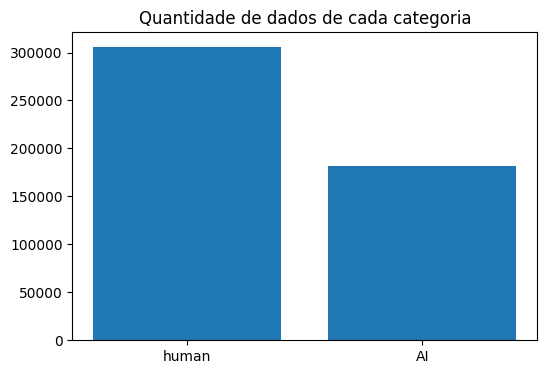

In [ ]:
quant_dados = pd.DataFrame(data['generated'].value_counts()).reset_index()
plt.figure(figsize=(6,4))
plt.title('Quantidade de dados de cada categoria')
plt.bar(quant_dados['generated'], quant_dados['count'])
plt.xticks(quant_dados['generated'], ['human', 'AI'])
plt.show()

In [ ]:
#selecionando apenas uma porção dos dados
data_simplified = data.drop(data.index[150000:])

In [ ]:
data_simplified['generated'].value_counts()

generated
0.0    85336
1.0    64664
Name: count, dtype: int64

Abaixo vemos a distribuição dos dados de cada categoria, agora para o conjunto de dados reduzido

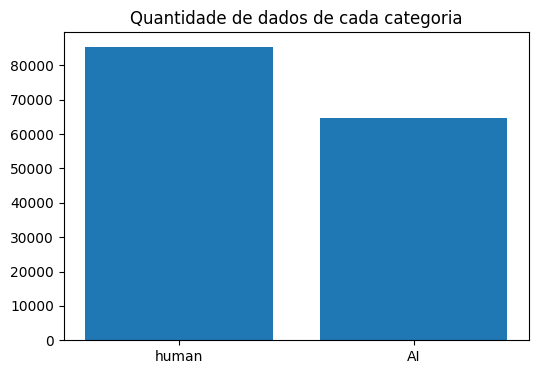

In [ ]:
quant_dados = pd.DataFrame(data_simplified['generated'].value_counts()).reset_index()
plt.figure(figsize=(6,4))
plt.title('Quantidade de dados de cada categoria')
plt.bar(quant_dados['generated'], quant_dados['count'])
plt.xticks(quant_dados['generated'], ['human', 'AI'])
plt.show()

In [ ]:
del data

###Removendo Stopwords

Como parte do pré-processamento dos dados, removemos as stopwords dos textos utilizando uma função do NLTK

In [ ]:
#Removendo stopwords
nltk.download('stopwords')
stop = stopwords.words('english')

data_simplified['text_mod'] = data_simplified['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
#salvando os dados
data_simplified.to_csv('/content/drive/MyDrive/BERT_data/data_simplified.csv')

In [ ]:
del data_simplified

###Separação em treino e teste

Para essa etapa, optamos por separar os conjuntos de treino e teste numa proporção de 70/30

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(data_simplified['text_mod'], data_simplified['generated'], test_size=0.3, random_state=42)

###BERT Tokenizer

Utilizamos o BertTokenizer para essa tarefa. Como o modelo exige que os dados de treino e teste contenham os dados tokenizados junto de uma coluna com o texto original e uma coluna com os labels de cada texto, criamos um loop para que o formato final dos dados esteja correto

In [12]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
list_encoded = []
for row in range(x_train.shape[0]):
  texto = str(x_train.iloc[row])
  label = int(y_train.iloc[row])
  encode = tokenizer(texto, padding=True, truncation=True)
  encode['texto'] = texto
  encode['label'] = label
  list_encoded.append(encode)

In [ ]:
list_encoded_val = []
for row in range(x_val.shape[0]):
  texto = str(x_val.iloc[row])
  label = int(y_val.iloc[row])
  encode = tokenizer(texto, padding=True, truncation=True)
  encode['texto'] = texto
  encode['label'] = label
  list_encoded_val.append(encode)

In [ ]:
#salvando os dados
with open('/content/drive/MyDrive/BERT_data/token/list_encoded.pickle', 'wb') as file:
    pickle.dump(list_encoded, file)

In [ ]:
#salvando os dados
with open('/content/drive/MyDrive/BERT_data/token/list_encoded_val.pickle', 'wb') as file:
    pickle.dump(list_encoded_val, file)

In [6]:
with open('/content/drive/MyDrive/BERT_data/token/list_encoded_val.pickle', 'rb') as file:
    list_encoded_val = pickle.load(file)

In [7]:
with open('/content/drive/MyDrive/BERT_data/token/list_encoded.pickle', 'rb') as file:
    list_encoded = pickle.load(file)

In [9]:
#transformando as listas em Dataset (formato aceito pelo modelo)
eval_dataset = Dataset.from_list(list_encoded_val)
train_dataset = Dataset.from_list(list_encoded)

###Modelo

O modelo escolhido foi o BertForSequenceClassification, um modelo BERT já pré-treinado para classificação. Nessa etapa, definimos os parâmetros de treino e treinamos o modelo.

In [8]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [16]:
#parâmetros de treinamento
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=1,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=8,
    eval_strategy="epoch",
    save_strategy="epoch",
)

In [17]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer
)

In [19]:
trainer.train()


Epoch,Training Loss,Validation Loss
1,0.010400,0.007941


TrainOutput(global_step=6563, training_loss=0.027291967268024533, metrics={'train_runtime': 10798.2806, 'train_samples_per_second': 9.724, 'train_steps_per_second': 0.608, 'total_flos': 2.71060298120064e+16, 'train_loss': 0.027291967268024533, 'epoch': 1.0})

In [20]:
model.save_pretrained('./my_model')
tokenizer.save_pretrained('./my_model_tok')

('./my_model_tok/tokenizer_config.json',
 './my_model_tok/special_tokens_map.json',
 './my_model_tok/vocab.txt',
 './my_model_tok/added_tokens.json')

In [21]:
results = trainer.evaluate()
print(results)

{'eval_loss': 0.007941235788166523, 'eval_runtime': 1200.4762, 'eval_samples_per_second': 37.485, 'eval_steps_per_second': 4.686, 'epoch': 1.0}


O resultado final do nosso modelo apresenta uma loss de validação de apenas 0.0079, demonstrando ser um bom modelo, capaz de classificar bem os dados fornecidos a ele pelo dataset escolhido. Com uma melhor capacidade computacional, seria interessante observar a fundo a variação dos resultados ao longo de mais épocas e com mais dados disponíveis (considerando que utilizamos apenas uma pequena porção do dataset para o treinamento). No geral, o BERT se mostra um modelo custoso, mas eficiente para esta tarefa, sendo uma boa escolha como solução para o problema apresentado.